В вашем распоряжении набор данных о качестве сна Sleep_health_and_lifestyle_dataset.csv.
Ваша задача — подготовить данные к моделированию, сгенерировать новые признаки, применить методы отбора признаков для улучшения качества предсказательной модели и подобрать оптимальные гиперпараметры для модели регрессии.  

1. Предобработка данных:  
— Очистите данные от пропусков и аномалий.  
— Преобразуйте категориальные переменные с помощью One-Hot Encoding или Label Encoding.  

2. Генерация новых признаков:  
— Создайте комбинированные признаки, которые могут помочь улучшить модель.  
— Используйте полиномиальные признаки для числовых переменных.  

3. Отбор признаков:  
— Примените несколько методов отбора признаков (например, RFE, SelectKBest).  
— Сравните качество модели до и после отбора признаков.  

4. Подбор гиперпараметров:  
— Используйте GridSearchCV или RandomizedSearchCV для настройки параметров вашей модели регрессии.  
— Оцените, как изменение гиперпараметров влияет на качество предсказаний.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns


In [60]:
df = pd.read_csv('./Sleep_health_and_lifestyle_dataset.csv')

In [4]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


Информация о наборе данных:  
`Person ID: ` Идентификатор для каждого человека.  
`Gender:` Пол человека (мужчины/женщины).  
`Age:` Возраст человека в годах.  
`Occupation: ` Род занятий или профессия человека.  
`Sleep Duration (hours):` Количество часов, которые человек спит в сутки.  
`Quality of Sleep (scale: 1-10): `Субъективная оценка качества сна в диапазоне от 1 до 10.  
`Physical Activity Level (minutes/day):` Количество минут, которые человек ежедневно уделяет физической активности.  
`Stress Level (scale: 1-10):` Субъективная оценка уровня стресса, испытываемого человеком, в диапазоне от 1 до 10.  
`BMI Category: ` Категория ИМТ человека (например, недостаточный вес, нормальный, избыточный вес с избыточной массой тела).  
`Blood Pressure (systolic/diastolic): `Измерение артериального давления человека, показывающее превышение систолического давления над диастолическим давлением.  
`Heart Rate (bpm):` Частота сердечных сокращений человека в состоянии покоя в ударах в минуту.  
`Daily Steps:`  Количество шагов, которые человек делает за день.  
`Sleep Disorder:` Наличие или отсутствие у человека нарушений сна (отсутствие таковых, бессонница, апноэ во сне).

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [6]:
# Сгруппируем основную информацию о датасете.
import io
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
columns = s.splitlines()[3].split()
lines =   [line.split() for line in s.splitlines()[5:-2]]
lines = [[' '.join(row[1:-3]), row[-3], row[-2], row[-1]   ] for row in lines]
# lines
# columns[1:]
# df_info = pd.DataFrame(lines,columns=columns[1:])
# df_info['nu'] = df.nunique().values
# df.nunique().n
# df_info.join(df.nunique(), on='Column')
# df.nunique().to_frame(name='Columns').reset_index()
# pd.concat([pd.DataFrame(lines,columns=columns[1:]), df.nunique()], axis=1, ignore_index=True)# .set_index(['#']).reset_index()
df_info = pd.merge(pd.DataFrame(lines,columns=columns[1:]), df.nunique().to_frame(name='Nu'), left_on='Column', right_index=True)# .set_index(['#']).reset_index()
df_vc = pd.DataFrame([[col, sorted(df[col].value_counts().to_dict().items(), key=lambda x: x[0])] for col in df.columns if len(df[col].value_counts()) < 21], columns=['Column', 'vc'])
df_info = pd.merge(df_info, df_vc, how='left', on='Column')
df_info = pd.merge(df_info, df.describe().T, how='left', left_on='Column', right_index=True)
df_info.to_excel('./info.xlsx')
df_info


,Column,Non-Null,Count,Dtype,Nu,vc,count,mean,std,min,25%,50%,75%,max
0,Person ID,374,non-null,int64,374,NaN,374.0,187.500000,108.108742,1.0,94.25,187.5,280.75,374.0
1,Gender,374,non-null,object,2,"[(Female, 185), (Male, 189)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Age,374,non-null,int64,31,NaN,374.0,42.184492,8.673133,27.0,35.25,43.0,50.00,59.0
3,Occupation,374,non-null,object,11,"[(Accountant, 37), (Doctor, 71), (Engineer, 63...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sleep Duration,374,non-null,float64,27,NaN,374.0,7.132086,0.795657,5.8,6.40,7.2,7.80,8.5
5,Quality of Sleep,374,non-null,int64,6,"[(4, 5), (5, 7), (6, 105), (7, 77), (8, 109), ...",374.0,7.312834,1.196956,4.0,6.00,7.0,8.00,9.0
6,Physical Activity Level,374,non-null,int64,16,"[(30, 68), (32, 2), (35, 4), (40, 6), (42, 2),...",374.0,59.171123,20.830804,30.0,45.00,60.0,75.00,90.0
7,Stress Level,374,non-null,int64,6,"[(3, 71), (4, 70), (5, 67), (6, 46), (7, 50), ...",374.0,5.385027,1.774526,3.0,4.00,5.0,7.00,8.0
8,BMI Category,374,non-null,object,4,"[(Normal, 195), (Normal Weight, 21), (Obese, 1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Blood Pressure,374,non-null,object,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
# Целевой переменной является признак Quality of Sleep
# Датасет небольшой пропусков нет. Выбросов нет. 
# Средние значения числовых признаков не сильно отличаются от медианных значений
# Нулевые значения среди признаков отсутствуют
# Минимальные и максимальные значения явно не выходят за пределы допустимых значений.
# Часть признаков имеющих числовой формат можно отнести к категориальным переменным:
#  - Quality of Sleep, Stress Level.
# Остальные числовые переменные Age, Physical Activity Level, Heart Rate, Daily Steps можно рассматривать, 
# как числовые переменные потому, что эти признаки имеют естественную порядковую связь.
# Признак Person ID можно исключить, как не имеющий смысла.
if 'Person ID' in df.columns:
    df.drop(columns=['Person ID'], inplace=True)
df.head(2)


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None


In [62]:
# Пореобразуем данные артериального давления в две переменные BPS =  Blood Pressure systolic и BPD = Blood Pressure systolic - Blood Pressure diastolic
if 'bps' in df.columns:
    df.drop(columns=['bps'], inplace=True)
df['bps'] = df['Blood Pressure'].str.split('/').map(lambda x: int(x[0])) 
if 'bpd' in df.columns:
    df.drop(columns=['bps'], inplace=True)
df['bpd'] = df['Blood Pressure'].str.split('/').map(lambda x: int(x[0]) - int(x[1])) 
df.drop(columns=['Blood Pressure'], inplace=True)

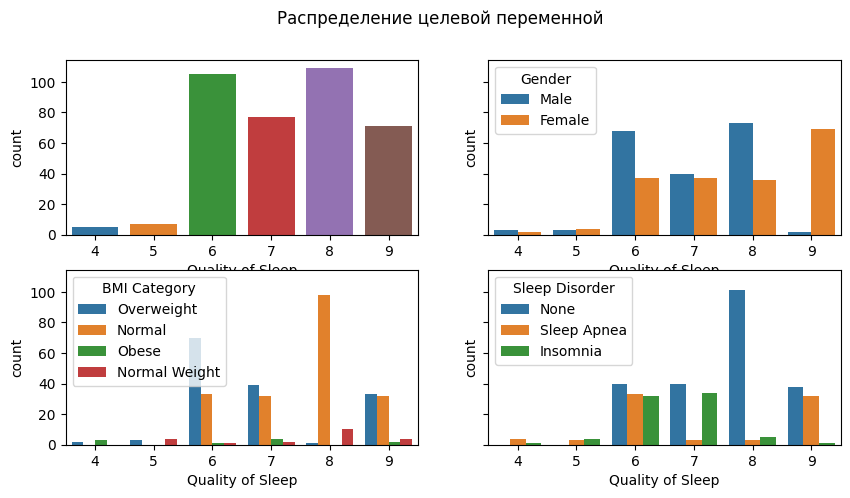

In [9]:
# Посмотрим на распределение целевой переменной

fig, axs = plt.subplots(2, 2, figsize=(10,5), sharey=True)
fig.suptitle('Распределение целевой переменной')
sns.countplot(ax=axs[0, 0], x='Quality of Sleep', data=df) # построение графика
sns.countplot(ax=axs[0, 1], x='Quality of Sleep', data=df,hue='Gender')
sns.countplot(ax=axs[1, 0], x='Quality of Sleep', data=df,hue='BMI Category')
sns.countplot(ax=axs[1, 1], x='Quality of Sleep', data=df,hue='Sleep Disorder');
# plt.figure(figsize=(6, 3))
# plt.subplot(1, 2, 1)
# sns.countplot(x='Quality of Sleep', data=df) # построение графика
# plt.title('Распределение целевой переменной', loc='center') # заголовок
# plt.ylabel('Количество значений', fontsize=10) # ось ординат
# plt.subplot(1, 2, 2)
# sns.countplot(x='Quality of Sleep', data=df,hue='Gender') # построение графика
# plt.xlabel('Качество сна', fontsize=10) # ось абсцисс
# plt.ylabel('Количество значений', fontsize=10); # ось ординат

# Отобразим распределение целевой переменной целевой переменной в целом и разделении по признакам Пол, Категория ИМТ, Нарушения сна.
# Наблюдаем в целом, что основное количество значений приходистя на оценки 6-9. Распределение целевой переменной не сбалансированное, что нужно учесть при формировании 
# тренировочной и тестовой выборки.
# В группых с оценкой 6, 8, 9 имеется сильное отличие между М и Ж. Если в группах с оценкой 6, 7 преобладают М, то в группе с оценкой 9 подавляющее большинство записей имеет признак Ж.
# По какой то причине М не оценивают качество сна с наивысшей оценкой.
# В группах с оценкой 4, 5 не представлены записи со значенями BMI Category равными Normal, Normal Weight. Записи со значением Obese представлены для всех оценок сна. Записи со значениями
#  Overweight, Normal представлены  в группах с оценкой 6 - 9. Каких то явных зависимостей нет.


In [10]:
# Определим признаки, которые обудем обрабатывать, как количественные данные. Указанные количественные данные относятся к подтипу дискретных количественных данных
# Несмотря на то, что значения признаков дискретные, их значения могут меняться в большом диапазоне (сложно заранее предопределить категории) и значения имеют порядковую связь.
numeric_features = ['Age', 'Sleep Duration', 'Physical Activity Level', 'bps', 'bpd', 'Heart Rate', 'Daily Steps']

c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been as

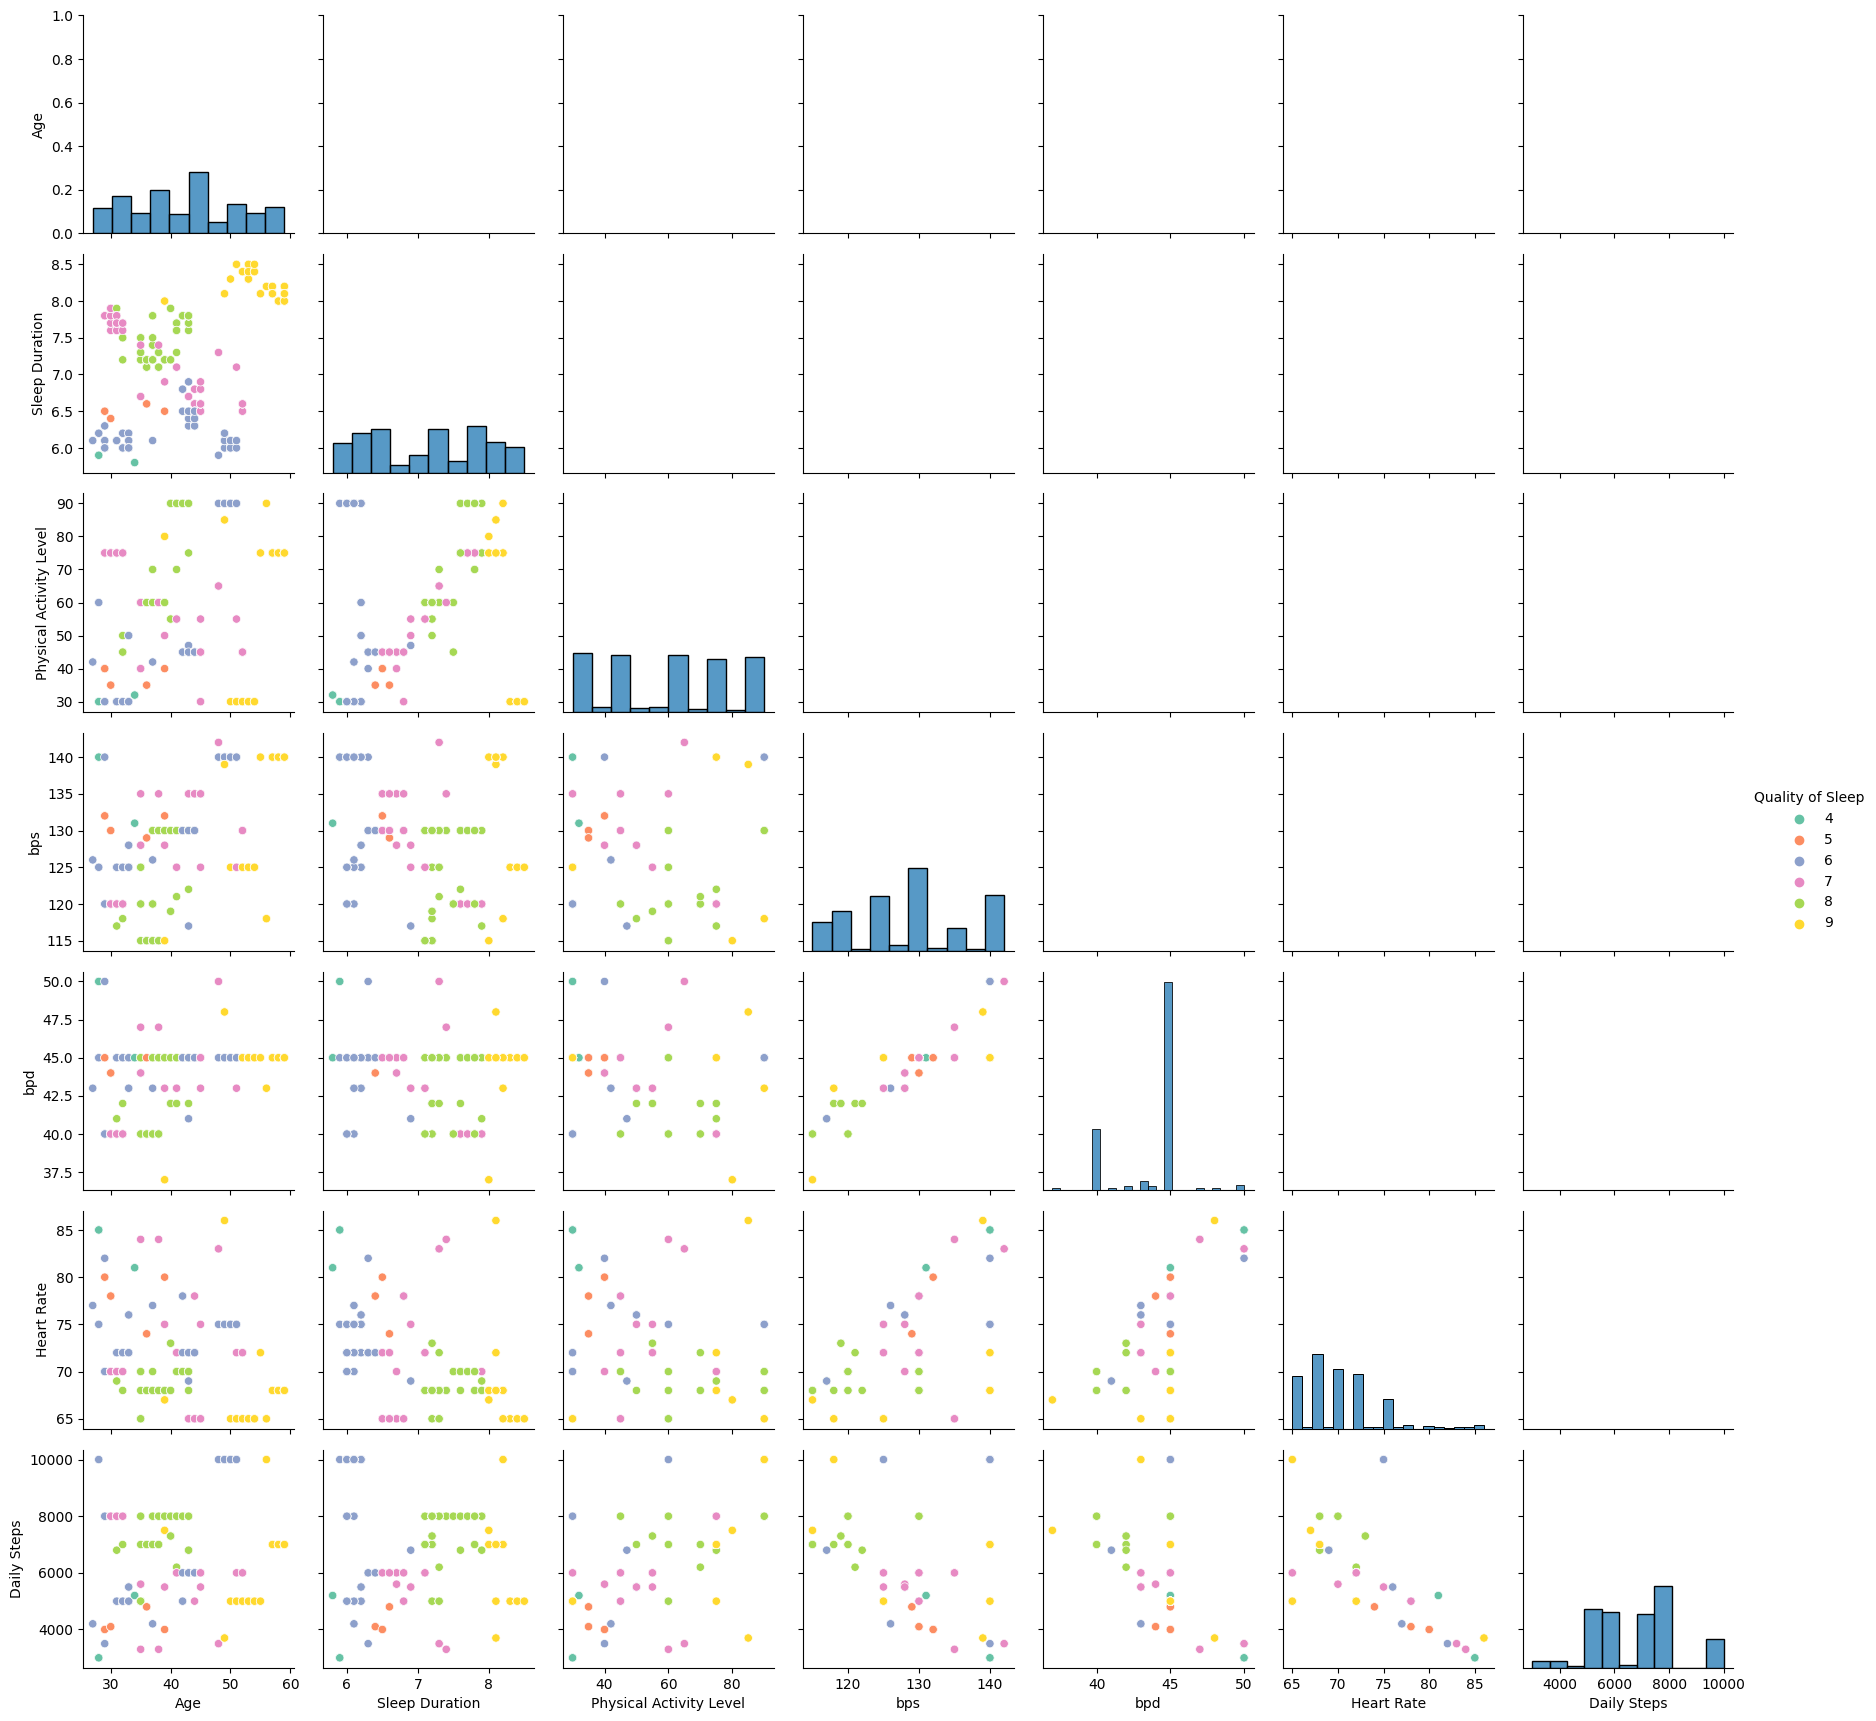

In [11]:
# Построим парную диаграмму между количественными признаками для выявления корреляций и отображения 
# sns.pairplot(df[numeric_features +['Quality of Sleep']], hue='Quality of Sleep', palette='Set1');
g = sns.PairGrid(df[numeric_features +['Quality of Sleep']], hue='Quality of Sleep', height = 2.5, palette='Set2')
g.map_diag(sns.histplot, hue=None)
g.map_lower(sns.scatterplot)
g.add_legend();

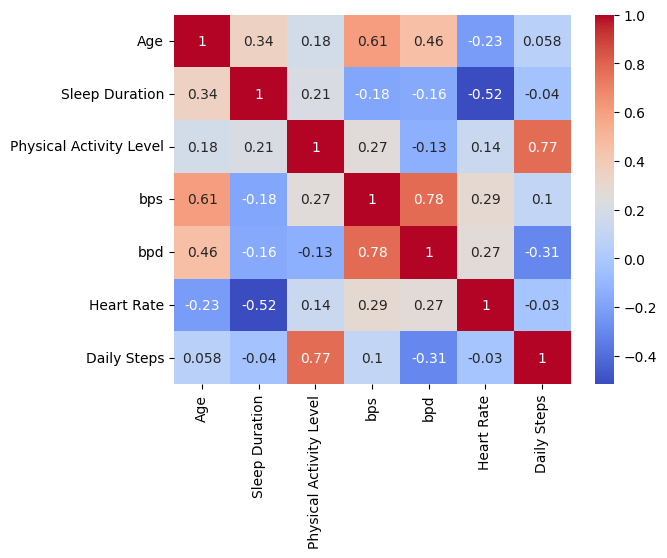

In [12]:
# Отобразим матрицу корреляций в виде тепловой карты
sns.heatmap(df[numeric_features].corr(), cmap='coolwarm',annot=True);
# По парным диаграммам можно увидеть отрицательную корреляцию между признаками 'Heart Rate', 'Daily Steps' но при расчете коэффициента корреляции этого явно не наблюдается.
# Можно попробовать выполнить перемножение этих признаков, чтобы оставить их в модели.
# По матрице корреляций наблюдается сильная положительная корреляция между признаками 'Daily Steps', 'Physical Activity Level', но на парном графике такой явной зависимости не наблюдается.

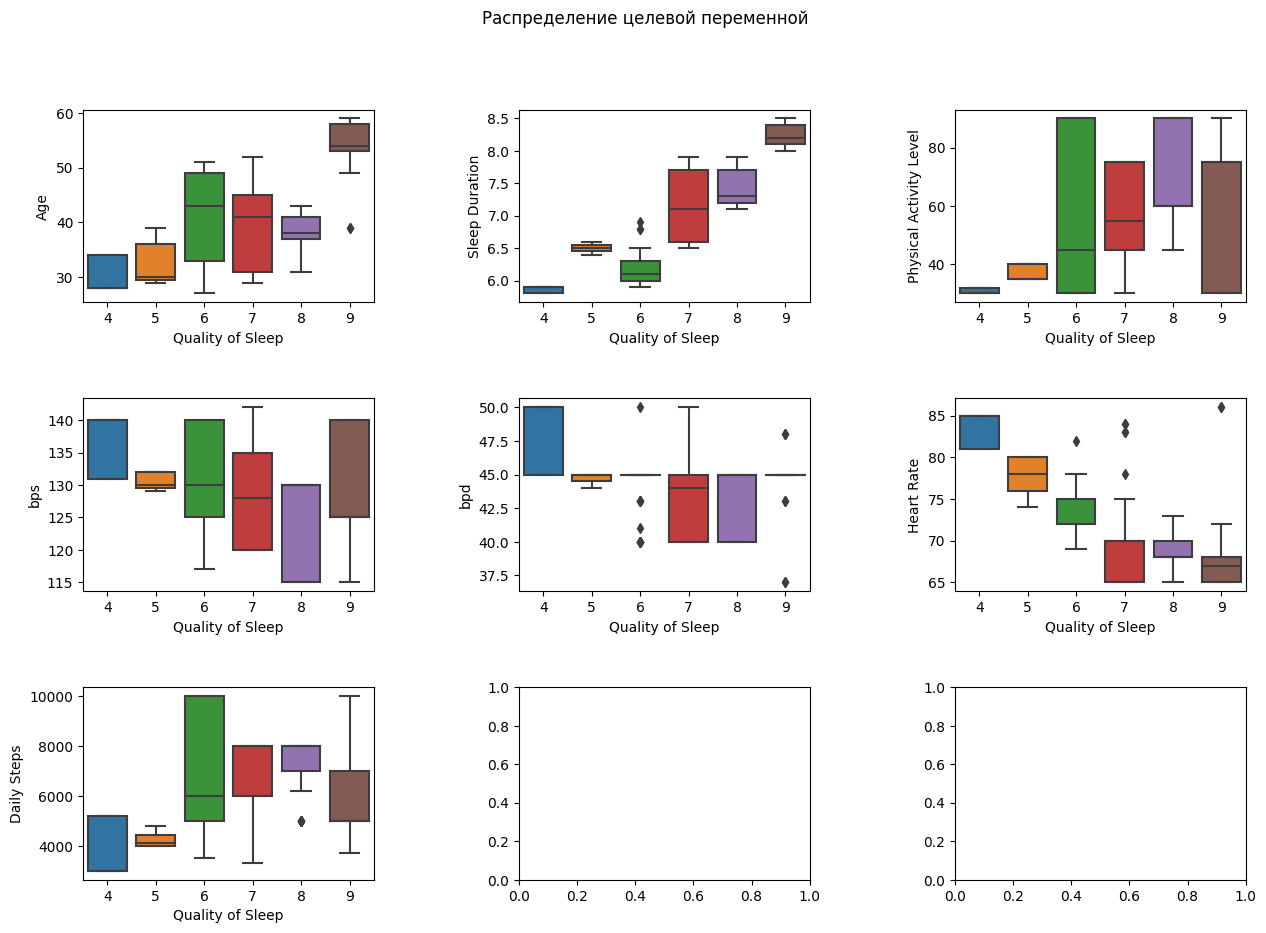

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Распределение целевой переменной')
sns.boxplot(ax=axs[0, 0], y='Age', data=df, x='Quality of Sleep')
sns.boxplot(ax=axs[0, 1], y='Sleep Duration', data=df, x='Quality of Sleep')
sns.boxplot(ax=axs[0, 2], y='Physical Activity Level', data=df, x='Quality of Sleep')
sns.boxplot(ax=axs[1, 0], y='bps', data=df, x='Quality of Sleep')
sns.boxplot(ax=axs[1, 1], y='bpd', data=df, x='Quality of Sleep')
sns.boxplot(ax=axs[1, 2], y='Heart Rate', data=df, x='Quality of Sleep')
sns.boxplot(ax=axs[2, 0], y='Daily Steps', data=df, x='Quality of Sleep')
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Как видно из графиков хорошей разделяющей способностью может обладать признаки 'Heart Rate', 'Sleep Duration'

In [14]:
# Определим направления работы с переменными, которые отнесем к категориальным.
cat_ord_features = ['Stress Level'] # Не будем преобразоывать. Переменная числовая, значения переменной имеют порядковую связь
ohe_features = ['Gender','BMI Category', 'Sleep Disorder'] # будем кодировать через One-Hot. Переменная строковая, значения при преобразовании могут не иметь очевидной порядковой связи
# набор значений предопределен, незменен. Возможных вариантов немного.
le_features = ['Occupation'] # Будем кодировать через Label-Encoding. Переменная строковая, значения при преобразовании не имеют порядковой связи. Количество возможных значений большое,э
# возможно появление новых значений

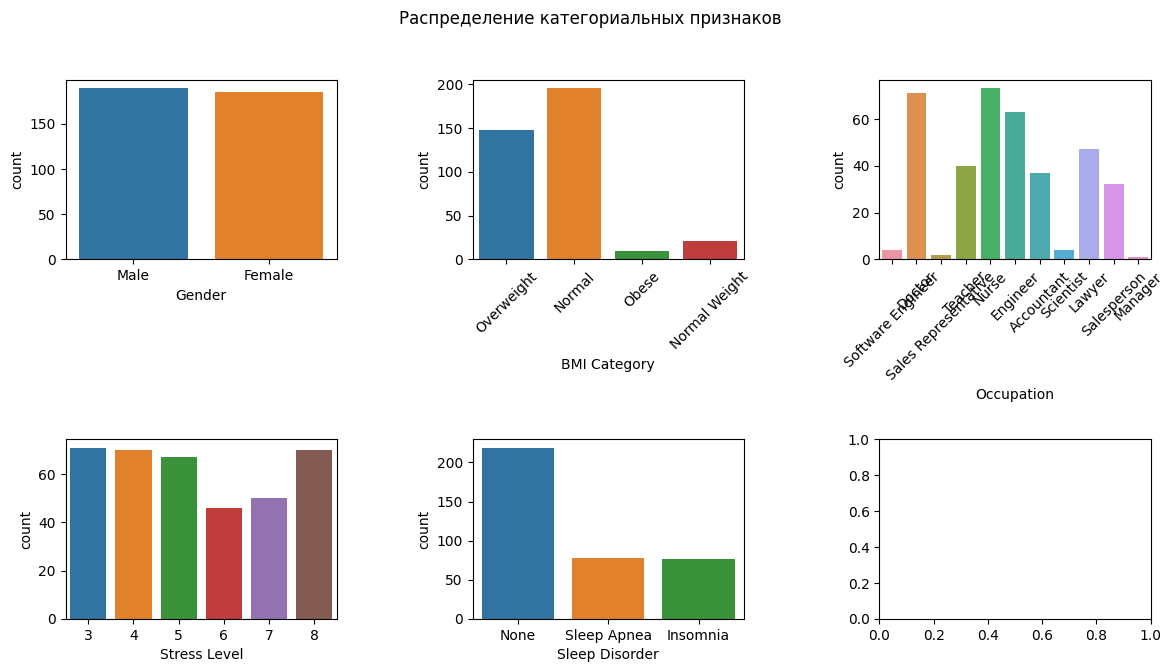

In [15]:
# Визуализируем распределения частоты встречи значений категориальных переменных
fig, axs = plt.subplots(2, 3, figsize=(14,7))
fig.suptitle('Распределение категориальных признаков')
sns.countplot(ax=axs[0, 0], x='Gender', data=df)
sns.countplot(ax=axs[1, 0], x='Stress Level', data=df)
sns.countplot(ax=axs[0, 1], x='BMI Category', data=df)
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=45)
sns.countplot(ax=axs[1, 1], x='Sleep Disorder', data=df)
sns.countplot(ax=axs[0, 2], x='Occupation', data=df)
axs[0,2].set_xticklabels(axs[0,2].get_xticklabels(), rotation=45)
plt.subplots_adjust(wspace=0.5, hspace=1)


In [24]:
# Преобразуем категориальные переменные
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [63]:
df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
df.head(3)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,bps,bpd
0,0,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,43
1,0,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,45
2,0,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,45


In [64]:
# Выполним ONE-HOT кодирование
# df_onehot = df.copy()
oh_encoder = OneHotEncoder(sparse_output = False)
oh_encoder.fit(df[ohe_features[1:]])
df = df.join(pd.DataFrame(oh_encoder.transform(df[ohe_features[1:]]), columns=oh_encoder.get_feature_names_out())) #.drop(columns=ohe_features[1:])



In [65]:
# Выполним Label кодирование
# 
df['Occupation_enc'] = df['Occupation'].map(df['Occupation'].value_counts())
df.head(4)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,bps,bpd,BMI Category_Normal,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder_Insomnia,Sleep Disorder_None,Sleep Disorder_Sleep Apnea,Occupation_enc
0,0,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,...,126,43,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
1,0,28,Doctor,6.2,6,60,8,Normal,75,10000,...,125,45,1.0,0.0,0.0,0.0,0.0,1.0,0.0,71
2,0,28,Doctor,6.2,6,60,8,Normal,75,10000,...,125,45,1.0,0.0,0.0,0.0,0.0,1.0,0.0,71
3,0,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,140,50,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2


In [66]:
df_encoded = df.copy()
df_encoded.drop(columns=ohe_features[1:], inplace=True)
df_encoded.drop(columns=le_features, inplace=True)
df_encoded.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,bps,bpd,BMI Category_Normal,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder_Insomnia,Sleep Disorder_None,Sleep Disorder_Sleep Apnea,Occupation_enc
0,0,27,6.1,6,42,6,77,4200,126,43,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
1,0,28,6.2,6,60,8,75,10000,125,45,1.0,0.0,0.0,0.0,0.0,1.0,0.0,71
2,0,28,6.2,6,60,8,75,10000,125,45,1.0,0.0,0.0,0.0,0.0,1.0,0.0,71
3,0,28,5.9,4,30,8,85,3000,140,50,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2
4,0,28,5.9,4,30,8,85,3000,140,50,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2


2. Генерация новых признаков:  
— Создайте комбинированные признаки, которые могут помочь улучшить модель.  
— Используйте полиномиальные признаки для числовых переменных.  

In [73]:
# Создадим комбинированные признаки, для улучшения модели.
# Из матрицы корреляций можно увидеть, что признаки bps и bpd, Physical Activity Level и Daily Steps имеют сильую положительную корреляцию
from sklearn.preprocessing import MinMaxScaler


In [78]:
# Нормализация данных
scaler = MinMaxScaler()
df_scale = df_encoded[['bps', 'bpd']].copy()
df_scale[['bps', 'bpd']] = scaler.fit_transform(df_encoded[['bps', 'bpd']])

# Выставление весов
bps_weight = 0.5  
bpd_weight = 0.5  

# Вычисление взвешенной суммы
if 'bp' in df_encoded.columns:
    df_encoded.drop(columns=['bp'])
df_encoded['bp'] = df_scale['bps'] * bps_weight + df_scale['bpd'] * bpd_weight
df_encoded.head(3)


,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,bps,bpd,BMI Category_Normal,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder_Insomnia,Sleep Disorder_None,Sleep Disorder_Sleep Apnea,Occupation_enc,bp
0,0,27,6.1,6,42,6,77,4200,126,43,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4,0.434473
1,0,28,6.2,6,60,8,75,10000,125,45,1.0,0.0,0.0,0.0,0.0,1.0,0.0,71,0.492877
2,0,28,6.2,6,60,8,75,10000,125,45,1.0,0.0,0.0,0.0,0.0,1.0,0.0,71,0.492877


In [79]:
from sklearn.preprocessing import PolynomialFeatures

In [87]:
poly_features = ['Physical Activity Level', 'Daily Steps']
scaler = MinMaxScaler()
df_poly = df_encoded[poly_features].copy()
df_poly[poly_features] = scaler.fit_transform(df_poly[poly_features])
poly_transformer = PolynomialFeatures(degree = 2)
poly_transformer.fit(df_poly)
df_poly = pd.DataFrame(poly_transformer.transform(df_poly), columns=poly_transformer.get_feature_names_out()).iloc[: , 3:]
df_poly

,Physical Activity Level^2,Physical Activity Level Daily Steps,Daily Steps^2
0,0.0400,0.034286,0.029388
1,0.2500,0.500000,1.000000
2,0.2500,0.500000,1.000000
3,0.0000,0.000000,0.000000
4,0.0000,0.000000,0.000000
...,...,...,...
369,0.5625,0.428571,0.326531
370,0.5625,0.428571,0.326531
371,0.5625,0.428571,0.326531
372,0.5625,0.428571,0.326531


In [121]:
df_encoded = df_encoded.join(df_poly)

In [125]:
if len(set(['bps', 'bpd']).intersection(set(df_encoded.columns))) > 0:
    df_encoded.drop(columns=['bps', 'bpd'], inplace=True)
if len(set(poly_features).intersection(set(df_encoded))) > 0:
    df_encoded.drop(columns=poly_features, inplace=True)

3. Отбор признаков:  
— Примените несколько методов отбора признаков (например, RFE, SelectKBest).  
— Сравните качество модели до и после отбора признаков.  

In [126]:
# Т.к. целевая переменная является категориальной, для прогнозирования будем исползовать модель логистической регресии
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [127]:
# Выполним масштабирование признаков
features_for_scale = ['Age', 'Sleep Duration', 'Stress Level', 'Heart Rate', 'Occupation_enc']
X = df_encoded.drop(columns=features_for_scale + ['Quality of Sleep']).join(pd.DataFrame(scaler.fit_transform(df_encoded[features_for_scale]), columns=features_for_scale))
X

,Gender,BMI Category_Normal,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder_Insomnia,Sleep Disorder_None,Sleep Disorder_Sleep Apnea,bp,Physical Activity Level^2,Physical Activity Level Daily Steps,Daily Steps^2,Age,Sleep Duration,Stress Level,Heart Rate,Occupation_enc
0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.434473,0.0400,0.034286,0.029388,0.00000,0.111111,0.6,0.571429,0.041667
1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.492877,0.2500,0.500000,1.000000,0.03125,0.148148,1.0,0.476190,0.972222
2,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.492877,0.2500,0.500000,1.000000,0.03125,0.148148,1.0,0.476190,0.972222
3,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.962963,0.0000,0.000000,0.000000,0.03125,0.037037,1.0,0.952381,0.013889
4,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.962963,0.0000,0.000000,0.000000,0.03125,0.037037,1.0,0.952381,0.013889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.770655,0.5625,0.428571,0.326531,1.00000,0.851852,0.0,0.142857,1.000000
370,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.770655,0.5625,0.428571,0.326531,1.00000,0.814815,0.0,0.142857,1.000000
371,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.770655,0.5625,0.428571,0.326531,1.00000,0.851852,0.0,0.142857,1.000000
372,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.770655,0.5625,0.428571,0.326531,1.00000,0.851852,0.0,0.142857,1.000000


In [128]:
y = df_encoded['Quality of Sleep']
y.shape

(374,)

In [156]:
# К сожалению из за несбалансированности классов невозможно получить полностью стратифицированные выборки.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42
                                                    # , stratify=df[['Gender', 'Stress Level', 'BMI Category']]
                                                     )

In [157]:
# Как видим, даже на простой модели имеются хорошее качество моделей, как на тренировочноый, так и на тестовой выборке. Переобучения не наблюдается.
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train,y_train)
y_pred = log_reg_model.predict(X_train)

accuracy_lr = accuracy_score(y_train, y_pred)
precision_lr = precision_score(y_train, y_pred, average='macro')
recall_lr = recall_score(y_train, y_pred, average='macro')
print('Тренировочная  выборка', accuracy_lr, precision_lr, recall_lr)

y_pred = log_reg_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr = precision_score(y_test, y_pred, average='macro')
recall_lr = recall_score(y_test, y_pred, average='macro')
print('Тестовая выборка', accuracy_lr, precision_lr, recall_lr)

Тренировочная  выборка 0.9464882943143813 0.798378415478203 0.7258171106013861
Тестовая выборка 0.9466666666666667 0.8086080586080587 0.8125


c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [158]:
# Применим метод отбора признаков RFE
from sklearn.feature_selection import RFE

In [159]:
# Создаем RFE модель и выбираем 3 признака
rfe = RFE(estimator=log_reg_model, n_features_to_select=10)
rfe = rfe.fit(X, y)

# Показываем какие признаки выбраны
ranked_features = pd.DataFrame({
    'Feature': X.columns,  # Здесь X.columns должен содержать названия столбцов, использованных для X
    'Ranking': rfe.ranking_
})
ranked_features = ranked_features.sort_values(by='Ranking', ascending=False)
print(ranked_features)

                                Feature  Ranking
10  Physical Activity Level Daily Steps        8
6                   Sleep Disorder_None        7
11                        Daily Steps^2        6
8                                    bp        5
3                    BMI Category_Obese        4
5               Sleep Disorder_Insomnia        3
9             Physical Activity Level^2        2
15                           Heart Rate        1
14                         Stress Level        1
13                       Sleep Duration        1
12                                  Age        1
0                                Gender        1
1                   BMI Category_Normal        1
7            Sleep Disorder_Sleep Apnea        1
4               BMI Category_Overweight        1
2            BMI Category_Normal Weight        1
16                       Occupation_enc        1


In [164]:
# Наблюдаем, что полиномиальные и сконструированные признаки имеют высокое влияние на модель
# Отберем признаки, имеющие высокое влияние
selected_features = ranked_features.loc[ranked_features['Ranking'] > 1]['Feature'].to_list()
selected_features

['Physical Activity Level Daily Steps',
 'Sleep Disorder_None',
 'Daily Steps^2',
 'bp',
 'BMI Category_Obese',
 'Sleep Disorder_Insomnia',
 'Physical Activity Level^2']

In [165]:
# Обучим модель на сокращенном наборе признаков.
# Метрики модели на тренировочном и валидационном датасетах сильно ухудшились
# Следовательно, сокращенного набора  признаков недостаточно для качестввенного прогнозирования
# Так же наблюдается переобучение, метрики на тренировочноый выборке хуже, чем на валидационной
log_reg_model_sf = LogisticRegression()
log_reg_model_sf.fit(X_train[selected_features],y_train)
y_pred = log_reg_model_sf.predict(X_train[selected_features])

accuracy_lr_sf = accuracy_score(y_train, y_pred)
precision_lr_sf = precision_score(y_train, y_pred, average='macro')
recall_lr_sf = recall_score(y_train, y_pred, average='macro')
print('Тренировочная  выборка', accuracy_lr_sf, precision_lr_sf, recall_lr_sf)

y_pred = log_reg_model_sf.predict(X_test[selected_features])
accuracy_lr_sf = accuracy_score(y_test, y_pred)
precision_lr_sf = precision_score(y_test, y_pred, average='macro')
recall_lr_sf = recall_score(y_test, y_pred, average='macro')
print('Тестовая выборка', accuracy_lr_sf, precision_lr_sf, recall_lr_sf)

Тренировочная  выборка 0.5719063545150501 0.3412760353153505 0.37995641515079054
Тестовая выборка 0.4533333333333333 0.28836329635768626 0.35443376068376065


c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4. Подбор гиперпараметров:  
— Используйте GridSearchCV или RandomizedSearchCV для настройки параметров вашей модели регрессии.  
— Оцените, как изменение гиперпараметров влияет на качество предсказаний.  

In [166]:
# Зададим параметры сетки
param_grid = [
    {'penalty':['l2', None], # Для мультиклассовой классификации в библиотеке sklearn можно использовать только l2 регуляризацию (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','sag','saga'], # Для мультиклассовой классификации в библиотеке sklearn можно использовать только указанные методы решения
    'max_iter'  : [50, 100, 1000, 2500] 
}
]

In [167]:
from sklearn.model_selection import GridSearchCV

In [177]:
log_model = LogisticRegression()
clf = GridSearchCV(log_model, param_grid = param_grid, cv = 3, n_jobs=-1)
clf



GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'max_iter': [50, 100, 1000, 2500],
                          'penalty': ['l2', None],
                          'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}])

In [178]:
best_clf = clf.fit(X_train[selected_features],y_train)
best_clf.best_estimator_

c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.0001, max_iter=1000, penalty=None)

In [179]:
# Наблюдаем улучшение метрики точности на тренировочной выборке
best_clf.best_score_

0.6287878787878788

In [180]:
# Наблюдаем значительное снижение метрики точности на валидационном датасете. 
# Модель переобучается
# Подобранные гиперпараметры ухудшили метрику точности модели и привели к увеличению переобучения
best_clf.best_estimator_.score(X_test[selected_features], y_test)

0.44